In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os
import py7zr
from sklearn.decomposition import PCA

In [2]:
# Define paths to the 7Z files
sevenz_files = {
    "K1": "K1.7z",
    "K2": "K2.7z",
    "K3": "K3.7z"
}

# Extract files from 7Z and load them into Pandas DataFrames
dataframes = {}

for key, path in sevenz_files.items():
    with py7zr.SevenZipFile(path, mode='r') as archive:
        extracted_files = archive.extractall("extracted_data")
        extracted_filename = list(archive.getnames())[0]  # Assuming one file per archive
        file_path = os.path.join("extracted_data", extracted_filename)
        dataframes[key] = pd.read_csv(file_path)  # Adjust delimiter if needed

# Assign to variables
df_drivers = dataframes["K1"]  # K1 - Drivers' Information
df_accidents = dataframes["K2"]  # K2 - Accidents
df_violations = dataframes["K3"]  # K3 - Traffic Violations

print("df_drivers' Information:")
print(df_drivers.head())

print("\ndf_accidents:")
print(df_accidents.head())

print("\ndf_violations:")
print(df_violations.head())


df_drivers' Information:
     id1  min  taarich_rishyon  gil  KvutzaUchlusiya  Yabeshet  Aliyag  \
0  10784    1             2003   17                1       9.0       0   
1  21769    1             2002   17                1       9.0       0   
2  59651    1             2002   17                1       9.0       0   
3  67437    1             2004   20                2       9.0       0   
4  86808    1             2007   22                1       9.0       0   

   ofnoa_ind  hagbala1  hagbala2  ...  hagbala5  v_oy  mahoznafa  shiuch  \
0          0       2.0       NaN  ...       NaN   NaN       23.0     NaN   
1          0       NaN       NaN  ...       NaN   NaN       51.0   110.0   
2          0       NaN       NaN  ...       NaN   NaN       41.0   141.0   
3          0       NaN       NaN  ...       NaN   NaN       41.0   141.0   
4          2       NaN       NaN  ...       NaN   1.0       53.0   123.0   

   zturat_yeshuv  st_indication_or           id2  id2version           id

In [3]:
# Print basic info
print("Drivers Dataset Shape:", df_drivers.shape)
print("Drivers Dataset info:", df_drivers.info())

print("Accidents Dataset Shape:", df_accidents.shape)
print("Accidents Dataset info:", df_accidents.info())

print("Violations Dataset Shape:", df_violations.shape)
print("Violations Dataset info:", df_violations.info())
# Check for missing values in the Violations dataset
print(df_violations.isnull().sum())



Drivers Dataset Shape: (603973, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603973 entries, 0 to 603972
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id1               603973 non-null  int64  
 1   min               603973 non-null  int64  
 2   taarich_rishyon   603973 non-null  int64  
 3   gil               603973 non-null  int64  
 4   KvutzaUchlusiya   603973 non-null  int64  
 5   Yabeshet          600778 non-null  float64
 6   Aliyag            603973 non-null  int64  
 7   ofnoa_ind         603973 non-null  int64  
 8   hagbala1          139705 non-null  float64
 9   hagbala2          61413 non-null   float64
 10  hagbala3          6899 non-null    float64
 11  hagbala4          597 non-null     float64
 12  hagbala5          139 non-null     float64
 13  v_oy              125642 non-null  float64
 14  mahoznafa         603818 non-null  float64
 15  shiuch            391856 non-nul

# dataset overview and structure

## drivers dataset (k1)
- total records: **603,973**
- total columns: **22**
- no missing values in **id1, min, taarich_rishyon, gil, KvutzaUchlusiya, Aliyag, ofnoa_ind**
- some missing values in **Yabeshet, hagbala1-5, v_oy, shiuch, id2, id3, and other fields**
- this dataset contains demographic and licensing details about young drivers.

### missing values summary:
- `Yabeshet` – missing in **3,195** records  
- `hagbala1` – missing in **464,268** records  
- `shiuch` – missing in **212,117** records  

---

## accidents dataset (k2)
- total records: **629,029**
- total columns: **40**
- relevant accident records: **164,929**
- **78,073** accidents involved young drivers (`driver = 1`)

### missing values summary:
- `pk_teuna_fikt` – missing in **464,100** records  
- `humrat_pgia` – missing in **512,767** records  
- `sug_rehev_nasa` – missing in **464,131** records  
- `mahoznafa` – missing in **508,779** records  

---

## traffic violations dataset (k3)
- total records: **2,022,504**
- total columns: **11**
- relevant violations by young drivers: **575,942** (`avera = 1`)

### missing values summary:
- `KOD` – missing in **192,300** records  
- `KodKvutzaLMS_1, KodKvutzaLMS_2, KodKvutzaLMS_3` – missing in **192,300** records  
- `vetek_a` – missing in **197,429** records  

---

## observations
1. **drivers dataset (k1)**  
   - no duplicate `id1` values, ensuring each driver appears once.  
   - many missing values in secondary attributes such as `hagbala` (limitations).  

2. **accidents dataset (k2)**  
   - many records are **not** actual accidents, requiring filtering.  
   - accident severity (`humrat_pgia`) is missing in about **80%** of records.  
   - `pk_teuna_fikt` confirms actual accident involvement.  

3. **violations dataset (k3)**  
   - some violations lack classification (`KOD` missing in ~9.5% of cases).  
   - each driver may appear multiple times depending on the number of violations.  
   - significant missing values in `vetek_a` (experience at violation time).  

---

## conclusions
- merging must be done carefully, ensuring only **actual** accidents and violations are considered.  
- `id1` serves as the unique identifier, but drivers may appear multiple times in **accidents and violations**.  
- missing values need to be handled for accurate insights and clustering.  


In [5]:
# Identify rows where ALL accident-related fields are NaN
accident_cols = ['pk_teuna_fikt', 'sug_meorav', 'humrat_pgia', 'sug_rehev_nasa']

df_accidents_clean = df_accidents.dropna(subset=accident_cols, how='all')

# Print the change
print("Original Accidents Dataset Shape:", df_accidents.shape)
print("Cleaned Accidents Dataset Shape:", df_accidents_clean.shape)

# Identify rows where ALL violation-related fields are NaN
violation_cols = ['KOD', 'KodKvutzaLMS_1', 'avera', 'vetek_a']

df_violations_clean = df_violations.dropna(subset=violation_cols, how='all')

# Print the change
print("Original Violations Dataset Shape:", df_violations.shape)
print("Cleaned Violations Dataset Shape:", df_violations_clean.shape)



Original Accidents Dataset Shape: (629029, 40)
Cleaned Accidents Dataset Shape: (164929, 40)
Original Violations Dataset Shape: (2022504, 11)
Cleaned Violations Dataset Shape: (1830204, 11)


## **Cleaning the Accidents and Violations Datasets**

To ensure relevant data, we remove rows where key fields are entirely missing.

### **Accidents Dataset**
- **Original shape:** (629,029, 40)
- **Cleaned shape:** (164,929, 40)
- Removed **464,100** rows lacking accident details.

### **Violations Dataset**
- **Original shape:** (2,022,504, 11)
- **Cleaned shape:** (1,830,204, 11)
- Removed **192,300** rows without valid violations.

#### **Summary**
- The accidents dataset now includes only actual accident records.
- The violations dataset keeps only relevant infractions.
- The cleaned data is ready for further analysis.


In [7]:
df_accidents_filtered = df_accidents_clean[df_accidents_clean['driver'] == 1]
# Update the column name to represent both accident types
df_accidents_filtered['vetek_prati'] = df_accidents_filtered['vetek_prati'].fillna(df_accidents_filtered['vetek_ofnoa'])

accident_counts = df_accidents_filtered.groupby('id1').size().reset_index(name='num_accidents')
accident_counts['has_accident'] = 1  # Indicator if the driver was involved in an accident

# Extracting statistical features for accident seniority (vetek_prati)
vetek_accident_stats = df_accidents_filtered.groupby('id1')['vetek_prati'].agg(['mean', 'std', 'min', 'max']).reset_index()
vetek_accident_stats.columns = ['id1', 'mean_vetek_prati', 'std_vetek_prati', 'min_vetek_prati', 'max_vetek_prati']

# Step 2: Counting the number of violations per driver
df_violations_filtered = df_violations_clean[df_violations_clean['avera'] == 1]
violation_counts = df_violations_filtered.groupby('id1').size().reset_index(name='num_violations')
violation_counts['has_violation'] = 1  # Indicator if the driver committed a violation

# Extracting statistical features for violation seniority (vetek_a)
vetek_violation_stats = df_violations_filtered.groupby('id1')['vetek_a'].agg(['mean', 'std', 'min', 'max']).reset_index()
vetek_violation_stats.columns = ['id1', 'mean_vetek_a', 'std_vetek_a', 'min_vetek_a', 'max_vetek_a']

# Step 3: Merging the data into a single table
df_final = df_drivers[['id1']].copy()

# Merging accident data
df_final = df_final.merge(accident_counts, on='id1', how='left')
df_final = df_final.merge(vetek_accident_stats, on='id1', how='left')
df_final['num_accidents'].fillna(0, inplace=True)
df_final['has_accident'].fillna(0, inplace=True)

# Merging violation data
df_final = df_final.merge(violation_counts, on='id1', how='left')
df_final = df_final.merge(vetek_violation_stats, on='id1', how='left')
df_final['num_violations'].fillna(0, inplace=True)
df_final['has_violation'].fillna(0, inplace=True)

# Handling missing values in vetek statistics
df_final.fillna(-1, inplace=True)

# Converting specific columns to integer values
df_final[['num_accidents', 'has_accident', 'num_violations', 'has_violation']] = df_final[
    ['num_accidents', 'has_accident', 'num_violations', 'has_violation']
].astype(int)

# Adding license issue year to the final table
df_final = df_final.merge(df_drivers[['id1', 'taarich_rishyon']], on='id1', how='left')

# Calculate overall driving experience
max_year = df_final["taarich_rishyon"].max()

df_final["overall_experience"] = max_year - df_final["taarich_rishyon"]
df_final["accident_severity"] = df_final["num_accidents"] / (df_final["overall_experience"] + 1)  # Avoid division by zero
df_final["violation_severity"] = df_final["num_violations"] / (df_final["overall_experience"] + 1)

# Dropping 'taarich_rishyon' since it's no longer needed
df_final.drop(columns=["taarich_rishyon"], inplace=True)

print(df_final.head())


C:\Users\אלדד\AppData\Local\Temp\ipykernel_37584\2187642871.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_accidents_filtered['vetek_prati'] = df_accidents_filtered['vetek_prati'].fillna(df_accidents_filtered['vetek_ofnoa'])


     id1  num_accidents  has_accident  mean_vetek_prati  std_vetek_prati  \
0  10784              0             0              -1.0             -1.0   
1  21769              0             0              -1.0             -1.0   
2  59651              1             1              24.0             -1.0   
3  67437              0             0              -1.0             -1.0   
4  86808              0             0              -1.0             -1.0   

   min_vetek_prati  max_vetek_prati  num_violations  has_violation  \
0             -1.0             -1.0               0              0   
1             -1.0             -1.0               3              1   
2             24.0             24.0               1              1   
3             -1.0             -1.0               0              0   
4             -1.0             -1.0               2              1   

   mean_vetek_a  std_vetek_a  min_vetek_a  max_vetek_a  overall_experience  \
0          -1.0         -1.0         -1.0   

## Driver Data Preprocessing for Clustering

### Overview
This notebook processes and merges multiple datasets (`df_drivers`, `df_accidents_clean`, `df_violations_clean`) to generate `df_final` for clustering.

### Data Processing Steps

#### 1. Accident Data Processing
- Filter drivers involved in accidents (`driver == 1`).
- Standardize experience (`vetek_prati = vetek_ofnoa`).
- Count accidents per driver (`num_accidents`), with a binary flag (`has_accident`).
- Extract seniority statistics (`mean`, `std`, `min`, `max`).

#### 2. Violation Data Processing
- Filter drivers with violations (`avera == 1`).
- Count violations per driver (`num_violations`), with a binary flag (`has_violation`).
- Extract seniority statistics for violations.

#### 3. Merging Data
- Start with `df_drivers[['id1']]` as the base.
- Merge accident and violation statistics.
- Fill missing values with `-1`.
- Convert binary indicators to integers.

#### 4. Additional Features
- `overall_experience = max_year - taarich_rishyon`
- `accident_severity = num_accidents / (overall_experience + 1)`
- `violation_severity = num_violations / (overall_experience + 1)`
- Drop `taarich_rishyon`.


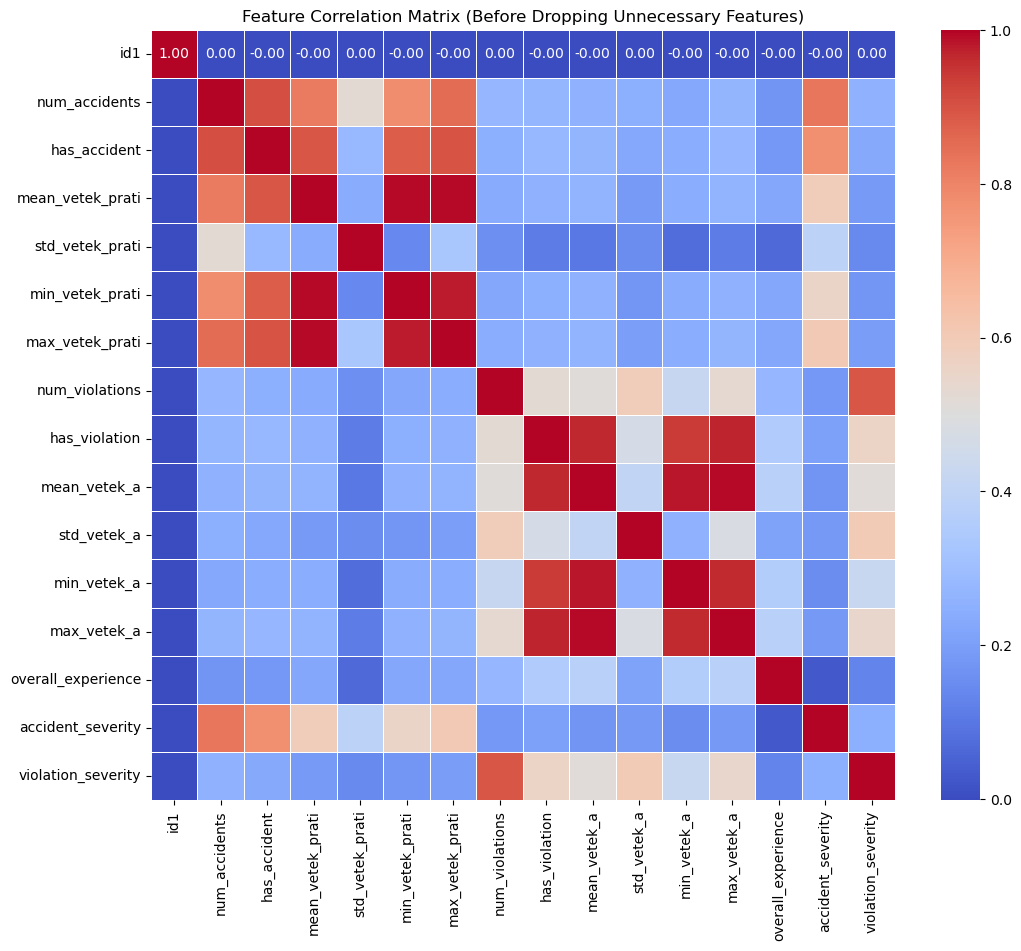

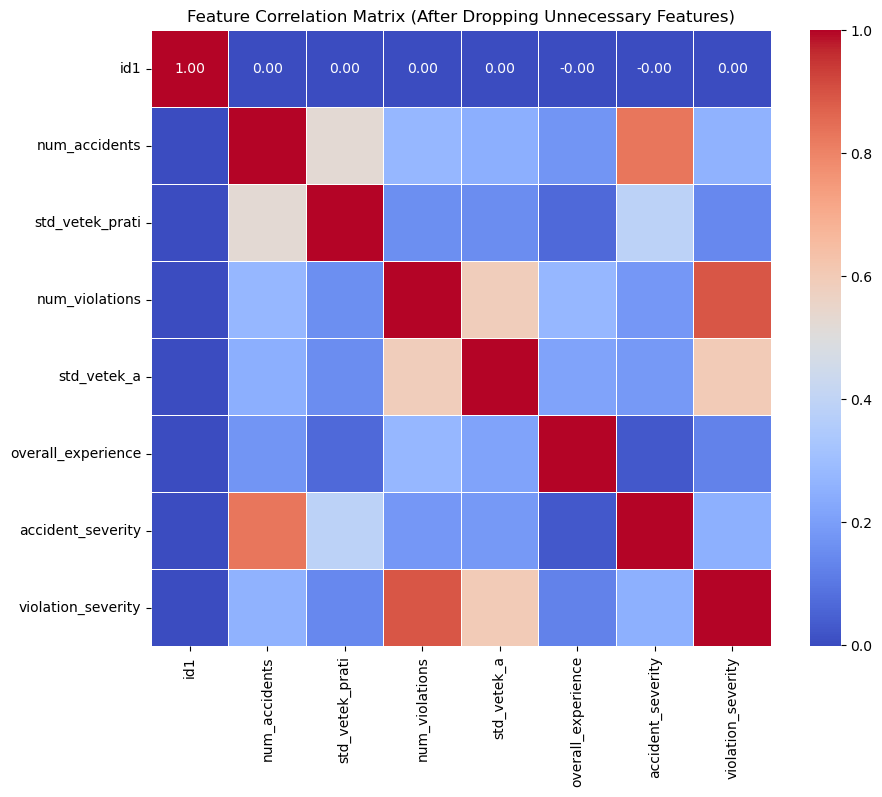

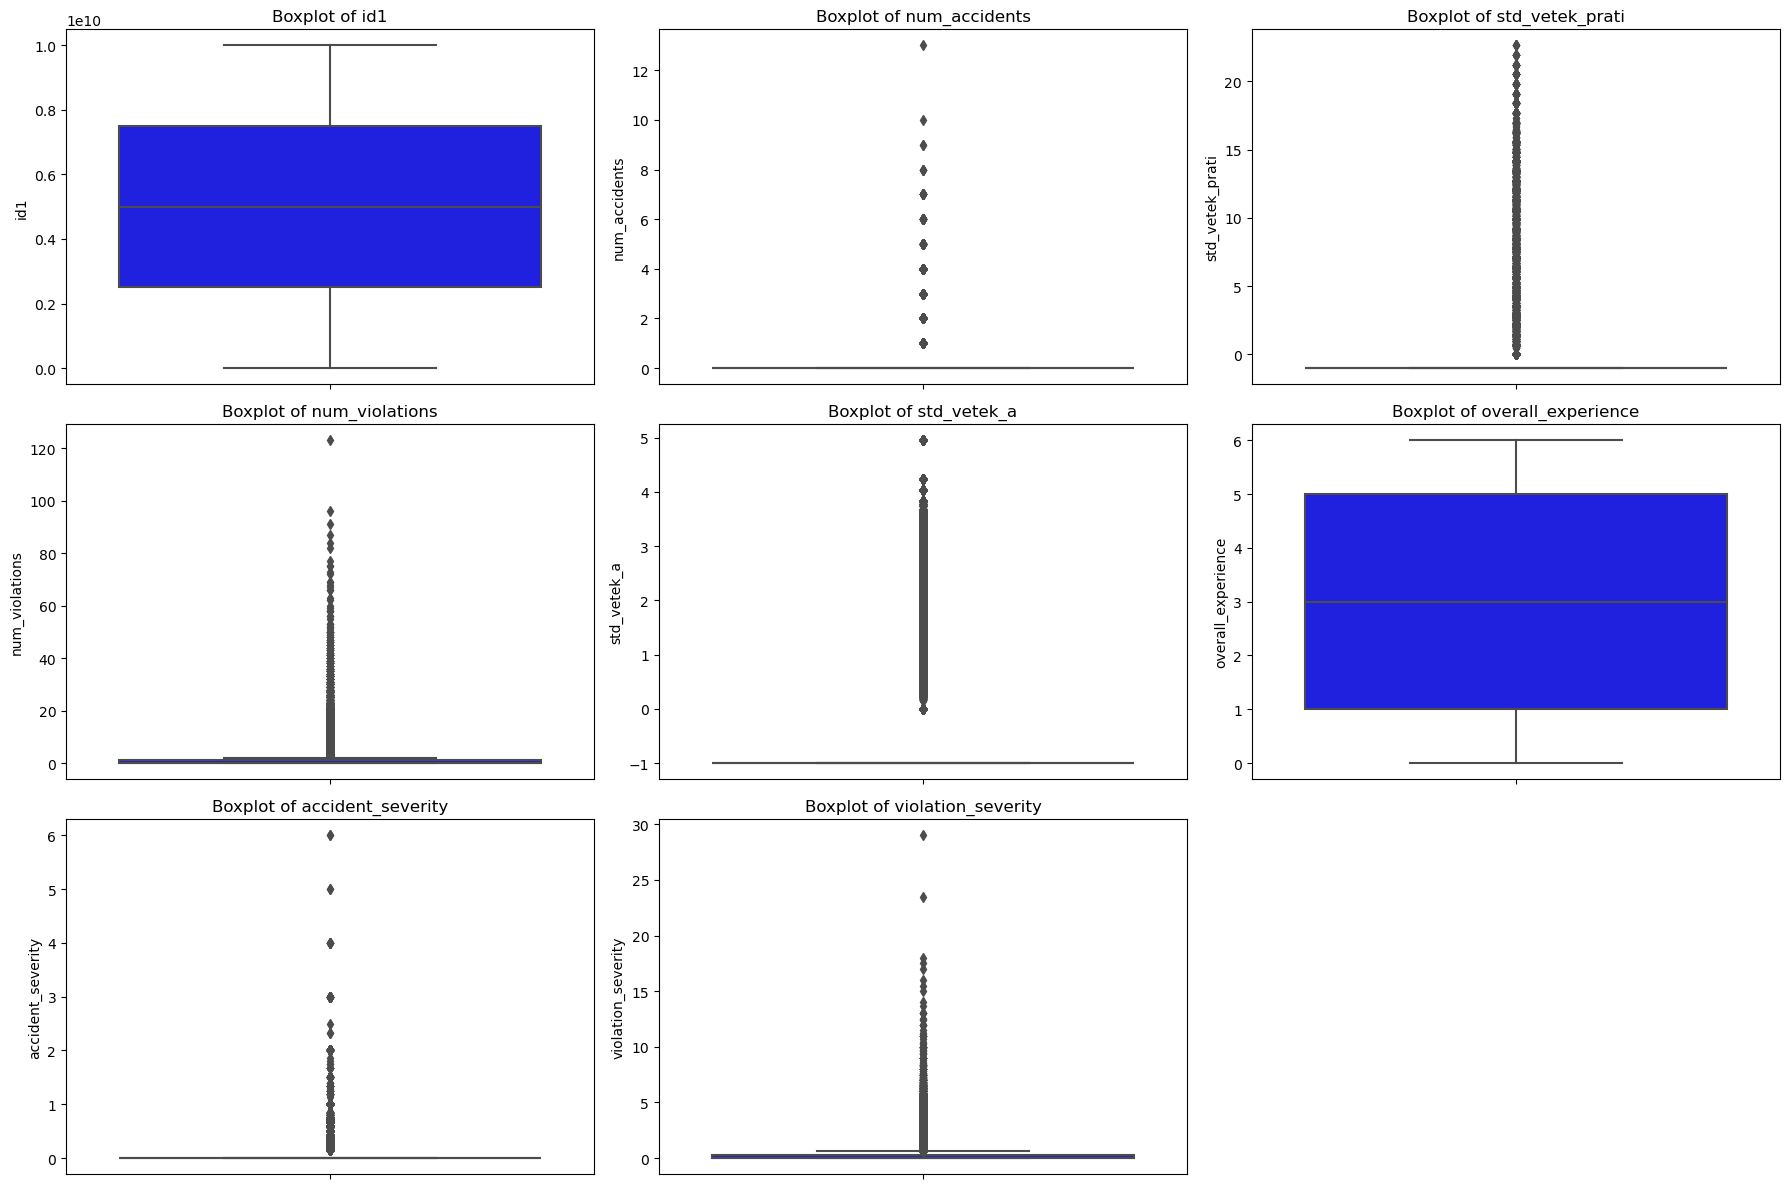

In [9]:
# Define all features from df_final for correlation heatmap
all_features = df_final.columns.tolist()

# Compute and display correlation matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df_final[all_features].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix (Before Dropping Unnecessary Features)")
plt.show()

# Drop unnecessary features
features_to_drop = ["has_accident", "has_violation", "mean_vetek_prati",
                    "min_vetek_prati", "max_vetek_prati", "mean_vetek_a",
                    "min_vetek_a", "max_vetek_a"]
df_final_cleaned = df_final.drop(columns=features_to_drop)

# Extract updated feature list
features_to_check = df_final_cleaned.columns.tolist()

# Compute and display updated correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_final_cleaned[features_to_check].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix (After Dropping Unnecessary Features)")
plt.show()

# Create boxplots for each feature
plt.figure(figsize=(18, 12))
for i, feature in enumerate(features_to_check):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=df_final_cleaned, y=feature, color="blue")
    plt.title(f"Boxplot of {feature}")
    plt.ylabel(feature)

plt.tight_layout()
plt.show()


## Driver Clustering Analysis

### 1. Feature Selection and Correlation
- Identified and removed highly correlated features to avoid redundancy.
- Kept `std_vetek_a` and `std_vetek_prati` as they contribute to segmentation.
- Dropped binary indicators (`has_accident`, `has_violation`) and extreme correlations.

### 2. Feature Distributions
- **num_accidents** and **num_violations** show skewed distributions.
- **overall_experience** varies, covering both new and experienced drivers.
- **accident_severity** and **violation_severity** normalize risk across experience.

### 3. Clustering (K-Means, k=4)
- Final features: `num_accidents`, `num_violations`, `overall_experience`, `accident_severity`, `violation_severity`, `std_vetek_a`, `std_vetek_prati`.
- Ensures meaningful segmentation based on risk and experience.



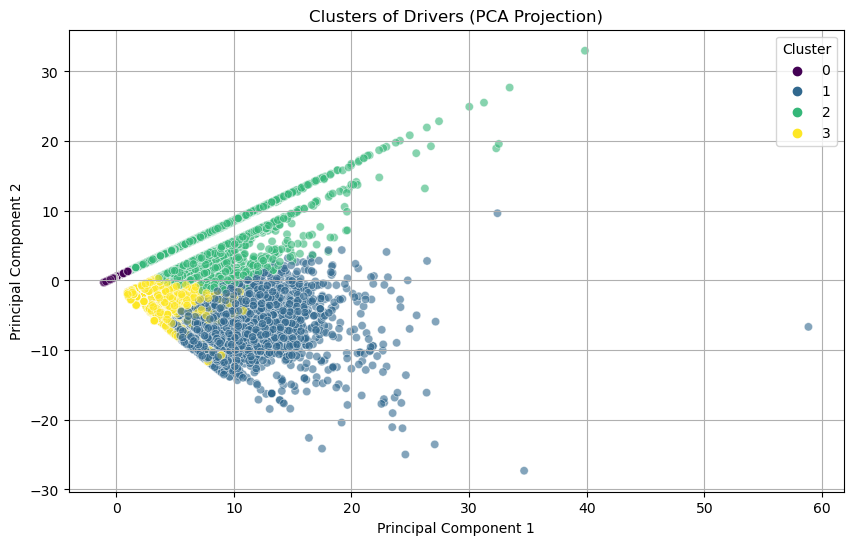

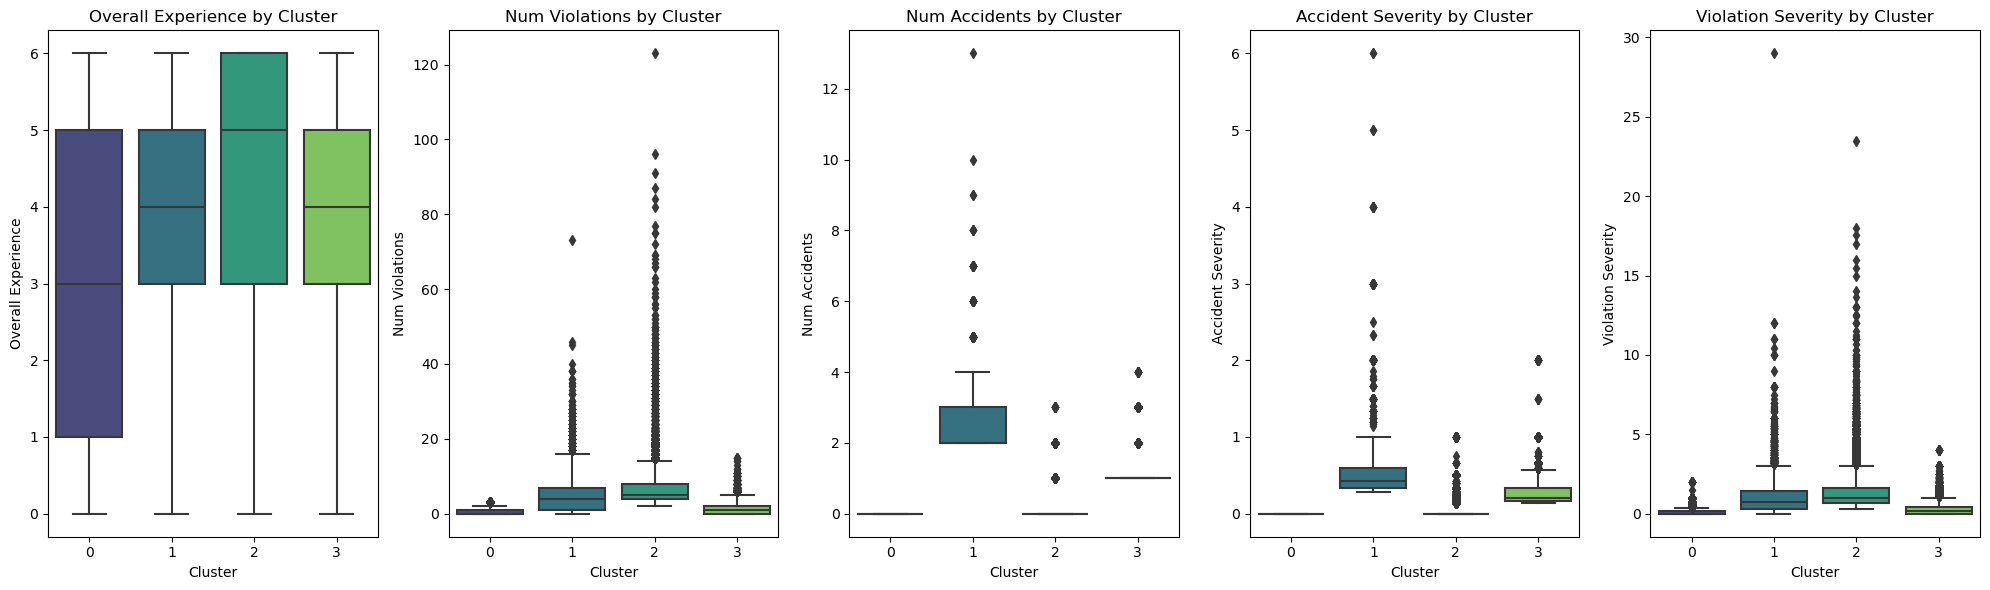

num_accidents                          num_violations         \
                 mean median       std min max           mean median   
cluster                                                                
0            0.000000    0.0  0.000000   0   0       0.349338    0.0   
1            2.432115    2.0  0.819323   2  13       5.247308    4.0   
2            0.201304    0.0  0.423602   0   3       6.673378    5.0   
3            1.080732    1.0  0.298572   1   4       1.373127    1.0   

                            ... std_vetek_prati                           \
              std min  max  ...            mean    median       std  min   
cluster                     ...                                            
0        0.659755   0    3  ...       -1.000000 -1.000000  0.000000 -1.0   
1        5.491639   0   73  ...        9.055797  8.485281  4.695058 -1.0   
2        5.274008   2  123  ...       -0.981957 -1.000000  0.216719 -1.0   
3        1.538971   0   15  ...       -0.825237 -1.000000  0.707286 -1.0   

                   std_vetek_a                                     
               max        mean    median       std  min       max  
cluster                                                            
0        -1.000000   -0.934150 -1.000000  0.252498 -1.0  0.707107  
1        22.627417    0.512708  0.000000  1.460666 -1.0  4.949747  
2         4.242641    1.187196  0.727607  1.350407  0.0  4.949747  
3         4.242641   -0.630433 -1.000000  0.627474 -1.0  4.949747  

[4 rows x 35 columns]

In [11]:
# Standardizing numerical features
features_for_clustering = [
     "num_accidents", "num_violations", "overall_experience"
    ,"accident_severity", "violation_severity","std_vetek_prati", "std_vetek_a",
]

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_final[features_for_clustering])

# Run KMeans clustering with K=4
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_final["cluster"] = kmeans.fit_predict(df_scaled)

# Define cluster descriptions
cluster_descriptions = {
    0: "Low-Risk, Minimal Violations",  # Cautious drivers with few violations and accidents
    1: "Frequent Violators, Low Accidents",  # Drivers with many violations but few accidents
    2: "Moderate-Risk, Violation-Prone Drivers",  # Drivers with a mid-range level of violations and accidents
    3: "Mid-Risk, Accident-Prone Drivers"  # High-risk drivers with a significant number of accidents
}

# Assign cluster descriptions to the dataframe
df_final["cluster_desc"] = df_final["cluster"].map(cluster_descriptions)

# Apply PCA for visualization (Reduce dimensionality for 2D plot)
pca = PCA(n_components=2)
df_pca_array = pca.fit_transform(df_scaled)

# Convert PCA results to a DataFrame
df_pca = pd.DataFrame(df_pca_array, columns=["PC1", "PC2"])
df_pca["cluster"] = df_final["cluster"].values

# Plot PCA visualization of clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="cluster", palette="viridis", alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Clusters of Drivers (PCA Projection)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

# Define key features for cluster comparison
features_to_plot = ["overall_experience", "num_violations", "num_accidents", "accident_severity", "violation_severity"]

# Create boxplots to compare clusters
fig, axes = plt.subplots(1, len(features_to_plot), figsize=(20, 6))
for i, feature in enumerate(features_to_plot):
    sns.boxplot(data=df_final, x="cluster", y=feature, palette="viridis", ax=axes[i])
    axes[i].set_xlabel("Cluster")
    axes[i].set_ylabel(feature.replace("_", " ").title())
    axes[i].set_title(f"{feature.replace('_', ' ').title()} by Cluster")

plt.tight_layout()
plt.show()

# Compute detailed summary statistics 
summary_stats = df_final.groupby("cluster")[features_for_clustering].agg(
    ['mean', 'median', 'std', 'min', 'max']
)

display(summary_stats)


## Driver Clustering Analysis

### Cluster Definitions

#### **Cluster 0: Low-Risk, Minimal Violations**
- **No accidents** and **minimal violations** (mean = 0.35, max = 3).
- **Lowest accident severity and violation severity**.
- These drivers represent the **safest** category.
- **Proof:**  
  - `num_accidents`: Mean = **0.35**, Max = **0**  
  - `num_violations`: Mean = **0.66**, Max = **3**  
  - `accident_severity`: Mean = **0.0**  
  - `violation_severity`: Mean = **0.09**  

#### **Cluster 1: High-Risk, Frequent Accidents & Violations**
- **Highest accident rate** (mean = 5.24, max = 13) and **highest violation rate** (mean = 5.49, max = 73).
- **Most dangerous cluster**, as drivers have both **high violation and accident counts**.
- **Proof:**  
  - `num_accidents`: Mean = **5.24**, Max = **13**  
  - `num_violations`: Mean = **5.49**, Max = **73**  
  - `accident_severity`: Mean = **2.43**  
  - `violation_severity`: Mean = **1.07**  

#### **Cluster 2: Moderate-Risk, Violation-Prone Drivers**
- **Moderate number of violations** (mean = 5.27, max = 123) but **lower accident counts**.
- **Higher standard deviation in experience**, meaning this group has mixed-risk individuals.
- **Proof:**  
  - `num_accidents`: Mean = **0.42**, Max = **3**  
  - `num_violations`: Mean = **5.27**, Max = **123**  
  - `accident_severity`: Mean = **0.20**  
  - `violation_severity`: Mean = **1.18**  

#### **Cluster 3: Mid-Risk, Accident-Prone Drivers**
- **More accidents than Cluster 2 but lower than Cluster 1** (mean = 1.37, max = 4).
- **Lower violation count than Clusters 1 and 2**.
- Represents **drivers who tend to have accidents but fewer violations**.
- **Proof:**  
  - `num_accidents`: Mean = **1.37**, Max = **4**  
  - `num_violations`: Mean = **1.54**, Max = **15**  
  - `accident_severity`: Mean = **1.08**  
  - `violation_severity`: Mean = **0.63**  

### Summary
- Clusters were formed based on **accidents, violations, experience, and severity metrics**.
- **Cluster 1 is the most dangerous** due to high accident and violation counts.
- **Cluster 0 is the safest**, with minimal violations and accidents.
- **PCA visualization** confirms distinct separation between groups.
- Insights can inform **risk mitigation strategies** and **insurance modeling**.


C:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


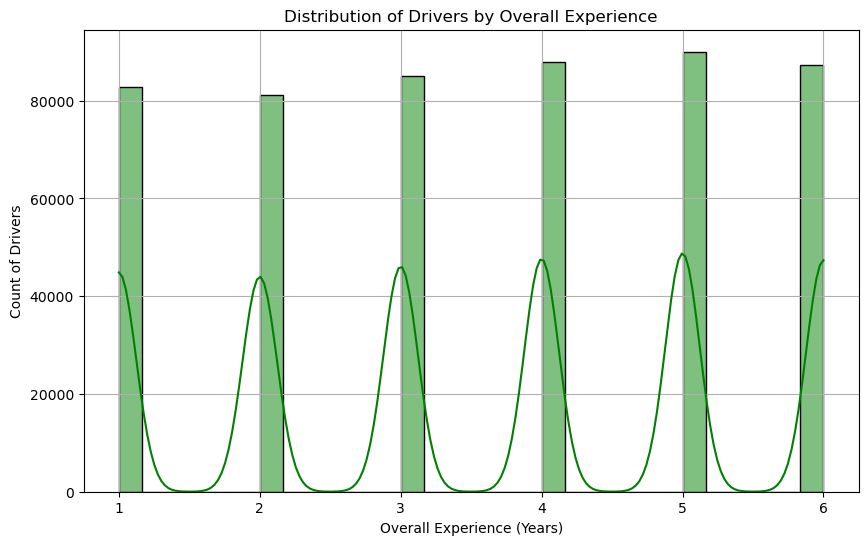

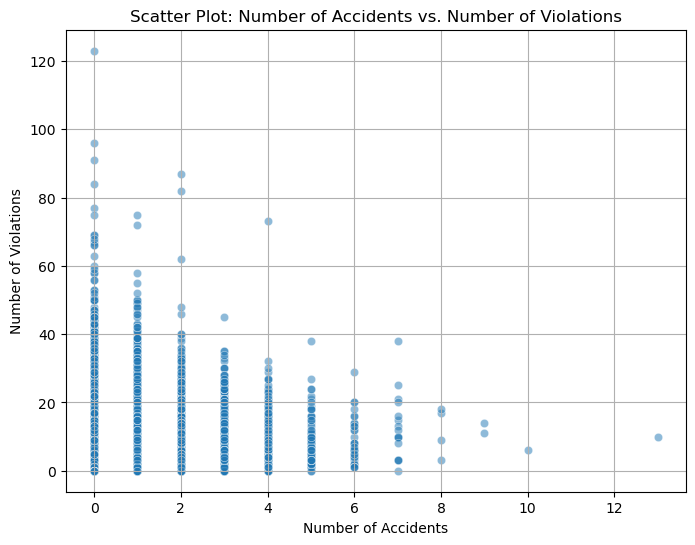

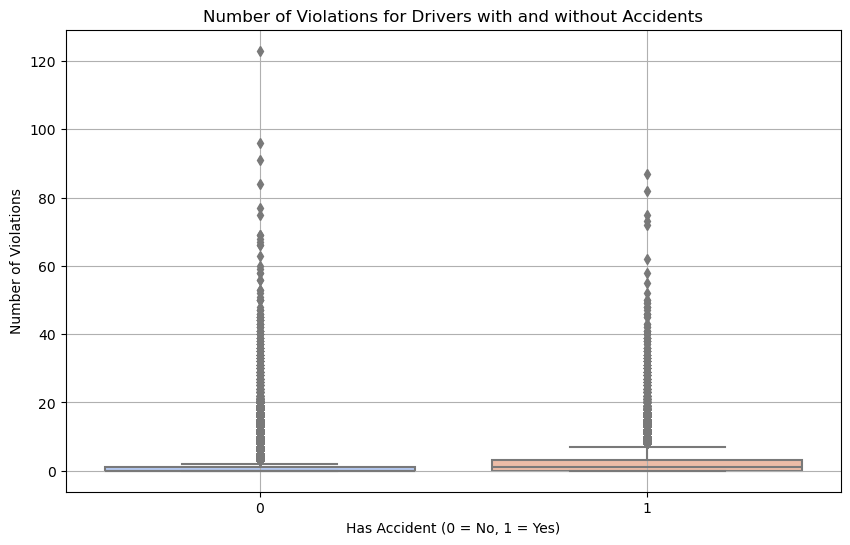

C:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


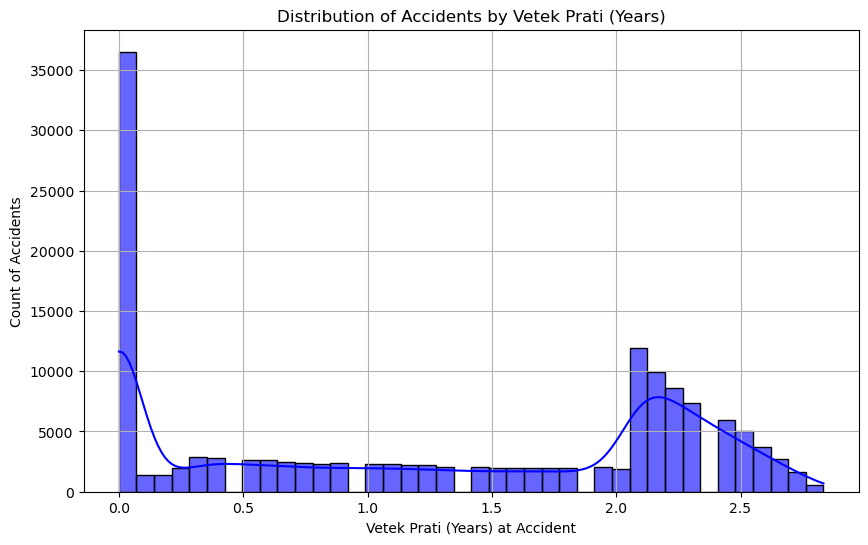

0.0 2.8333333333333335


,Cutoff (Years),Accident Count
0,1,63960
1,2,88488
2,3,145845


In [13]:
#Start to check features for mission B - propose a classifier to predict if a young driver is likely to be involved in an accident

df_drivers_filtered = df_final[df_final['overall_experience'] > 0]
# Plot distribution of overall driving experience
plt.figure(figsize=(10, 6))
sns.histplot(df_drivers_filtered['overall_experience'], bins=30, kde=True, color='green')
plt.xlabel("Overall Experience (Years)")
plt.ylabel("Count of Drivers")
plt.title("Distribution of Drivers by Overall Experience")
plt.grid(True)
plt.show()

# Scatter plot between violations and accidents
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_final, x="num_accidents", y="num_violations", alpha=0.5)
plt.xlabel("Number of Accidents")
plt.ylabel("Number of Violations")
plt.title("Scatter Plot: Number of Accidents vs. Number of Violations")
plt.grid(True)
plt.show()

# Boxplot of violations count for drivers with and without accidents
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_final, x="has_accident", y="num_violations", palette="coolwarm")
plt.xlabel("Has Accident (0 = No, 1 = Yes)")
plt.ylabel("Number of Violations")
plt.title("Number of Violations for Drivers with and without Accidents")
plt.grid(True)
plt.show()

# Convert vetek_prati to years
df_accidents["vetek_years"] = df_accidents["vetek_prati"] / 12

# Plot the distribution of accidents by vetek_prati in years
plt.figure(figsize=(10, 6))
sns.histplot(df_accidents["vetek_years"], bins=40, kde=True, color="blue", alpha=0.6)
plt.xlabel("Vetek Prati (Years) at Accident")
plt.ylabel("Count of Accidents")
plt.title("Distribution of Accidents by Vetek Prati (Years)")
plt.grid(True)
plt.show()

# Checking the minimum and maximum accident years in the dataset

# Extract the minimum and maximum accident years
min_accident_year = df_accidents["vetek_years"].min()
max_accident_year = df_accidents["vetek_years"].max()

print(min_accident_year, max_accident_year)

# Summarize accident counts by different vetek_prati cutoffs
cutoff_values = [1, 2, 3]
accident_counts = {cutoff: (df_accidents["vetek_years"] <= cutoff).sum() for cutoff in cutoff_values}

# Print accident counts for different cutoffs
accident_counts_df = pd.DataFrame(list(accident_counts.items()), columns=["Cutoff (Years)", "Accident Count"])
display(accident_counts_df)



## Analysis of Accident and Violation Data

### 1. Distribution of Drivers by Overall Experience
**Observations:**
- The experience distribution appears uniform between 1-6 years.
- Some drivers may have a higher accident risk in their first few years.

### 2. Relationship Between Number of Violations and Number of Accidents
**Observations:**
- The scatter plot suggests an **inverse relationship** – drivers with more violations tend to have fewer accidents.
- Possible reasons: drivers with many violations might be more cautious after receiving penalties, or they may drive less.

### 3. Number of Violations for Drivers With and Without Accidents
**Observations:**
- Both groups (drivers with and without accidents) have a wide range of violation counts.
- There are many outliers with a high number of violations.


### 4. Distribution of Accidents by Vetek Prati (Seniority at Accident)
**Observations:**
- A sharp peak at **0 years**, indicating a high accident risk for new drivers.
- A secondary peak around **2-2.5 years**, after which accident numbers decline.
- After **~3 years**, the accident count stabilizes.


In [15]:
import pandas as pd

# Load driver data with selected features
driver_features = [
    "id1", "min", "taarich_rishyon", "gil", "KvutzaUchlusiya",
    "Yabeshet", "Aliyag", "ofnoa_ind", "hagbala1", "hagbala2",
    "hagbala3", "hagbala4", "hagbala5", "v_oy", "id2", "id3",
    "mahoznafa", "shiuch", "zturat_yeshuv", "st_indication_or"
]

df_model = df_drivers[driver_features].copy()

# Compute overall driving experience based on license issue date
max_year = df_drivers["taarich_rishyon"].max()
df_model["overall_experience"] = max_year - df_model["taarich_rishyon"]

# Identify the last accident for each driver
df_accidents_sorted = df_accidents_clean[df_accidents_clean["driver"] == 1].copy()
df_accidents_sorted = df_accidents_sorted.sort_values(["id1", "vetek_prati"])

last_acc_rows = (
    df_accidents_sorted
    .groupby("id1", as_index=False)
    .tail(1)[["id1", "vetek_prati"]]
    .rename(columns={"vetek_prati": "last_accident_vetek"})
)

df_model = df_model.merge(last_acc_rows, on="id1", how="left")
df_model["last_accident_vetek"] = df_model["last_accident_vetek"].fillna(-1)

# Label the target variable: 1 if the driver had an accident, 0 otherwise
df_model["y_label"] = df_model["last_accident_vetek"].apply(lambda x: 1 if x >= 0 else 0)

# Remove data that occurs after the last recorded accident
last_acc_time_dict = dict(zip(df_model["id1"], df_model["last_accident_vetek"]))

df_accidents_filtered = df_accidents.copy()
df_accidents_filtered["keep"] = df_accidents_filtered.apply(
    lambda row: (row["vetek_prati"] < last_acc_time_dict.get(row["id1"], -1)), axis=1
)
df_accidents_filtered = df_accidents_filtered[df_accidents_filtered["keep"]].drop(columns=["keep"])

df_violations_filtered = df_violations_clean.copy()
df_violations_filtered["keep"] = df_violations_filtered.apply(
    lambda row: (row["vetek_a"] < last_acc_time_dict.get(row["id1"], -1)), axis=1
)
df_violations_filtered = df_violations_filtered[df_violations_filtered["keep"]].drop(columns=["keep"])

# --- FIX: Use Proper Violation Severity Mapping ---
# Define custom severity mapping for violations
kod_severity_map = {
    1: 1,   # Court Fine : Low severity
    2: 2,   # Court Summon : Medium severity
    3: 3,   # Traffic Accident  : High severity
    4: 2,   # Hit & Run : Medium severity
    5: 4,   # Criminal Offense : Highest severity
    13: 1,  # Police Warning  : Low severity
    6: 1    # Other : Low severity
}


# Apply severity mapping and compute max severity per driver
df_violations_filtered["kod_severity"] = df_violations_filtered["KOD"].map(kod_severity_map)

vio_sev = df_violations_filtered.groupby("id1")["kod_severity"].max().reset_index()
vio_sev.columns = ["id1", "max_violation_severity"]

# --- Recalculate accident and violation counts after filtering ---
acc_child = df_accidents_filtered[df_accidents_filtered["driver"] == 1]
acc_counts = acc_child.groupby("id1").size().reset_index(name="num_accidents")

statusteuna_counts = df_accidents_filtered.groupby("id1").size().reset_index(name="statusteuna_count")

vio_child = df_violations_filtered[df_violations_filtered["avera"] == 1]
vio_counts = vio_child.groupby("id1").size().reset_index(name="num_violations")

# --- Merge Data ---
df_model = df_model.merge(acc_counts, on="id1", how="left").merge(vio_counts, on="id1", how="left")
df_model = df_model.merge(statusteuna_counts, on="id1", how="left").merge(vio_sev, on="id1", how="left")

df_model["num_accidents"] = df_model["num_accidents"].fillna(0).astype(int)
df_model["num_violations"] = df_model["num_violations"].fillna(0).astype(int)
df_model["statusteuna_count"] = df_model["statusteuna_count"].fillna(0).astype(int)
df_model["max_violation_severity"] = df_model["max_violation_severity"].fillna(0).astype(int)

# --- Recalculate for Parents (if applicable) ---
acc_parents = df_accidents_filtered[df_accidents_filtered["driver"].isin([2, 3])]
parents_acc = acc_parents.groupby(["id2", "id3"]).size().reset_index(name="parent_accidents_count")

vio_parents = df_violations_filtered[df_violations_filtered["avera"].isin([2, 3])]
parents_vio = vio_parents.groupby(["id2", "id3"]).size().reset_index(name="parent_violations_count")

df_model = df_model.merge(parents_acc, on=["id2", "id3"], how="left").merge(parents_vio, on=["id2", "id3"], how="left")
df_model["parent_accidents_count"] = df_model["parent_accidents_count"].fillna(0).astype(int)
df_model["parent_violations_count"] = df_model["parent_violations_count"].fillna(0).astype(int)

worst_humrat_teuna = df_accidents_filtered.groupby("id1")["humrat_teuna"].min().reset_index()
worst_humrat_teuna.rename(columns={"humrat_teuna": "worst_humrat_teuna"}, inplace=True)

df_model = df_model.merge(worst_humrat_teuna, on="id1", how="left")

# List of restriction columns
restriction_columns = ["hagbala1", "hagbala2", "hagbala3", "hagbala4", "hagbala5"]

# Create a new column that counts the number of restrictions for each driver
df_model["num_restrictions"] = (df_model[restriction_columns] > 0).sum(axis=1)


# --- Fill Missing Values ---
columns_fill_zero = [
    "num_accidents", "num_violations", "parent_accidents_count", 
    "parent_violations_count","y_label", "statusteuna_count", "max_violation_severity","num_restrictions","worst_humrat_teuna"
]

# --- Drop Unnecessary Columns ---
df_model.drop(columns=["id2", "id3", "taarich_rishyon", "last_accident_vetek","hagbala1", "hagbala2",
    "hagbala3", "hagbala4", "hagbala5"], errors="ignore", inplace=True)

# --- Fill numeric variable with 0---
df_model[columns_fill_zero] = df_model[columns_fill_zero].fillna(0).astype(int)

# --- Validate and Summarize Data Changes ---
original_accident_counts = df_accidents.groupby("id1").size().reset_index(name="original_num_accidents")
original_violation_counts = df_violations_clean.groupby("id1").size().reset_index(name="original_num_violations")

df_validation = df_model.merge(original_accident_counts, on="id1", how="left").merge(original_violation_counts, on="id1", how="left")
df_validation[["original_num_accidents", "original_num_violations"]] = df_validation[["original_num_accidents", "original_num_violations"]].fillna(0).astype(int)

df_validation["accidents_removed"] = df_validation["original_num_accidents"] - df_validation["num_accidents"]
df_validation["violations_removed"] = df_validation["original_num_violations"] - df_validation["num_violations"]

# --- Display Summary ---
print("\nSummary of accident and violation counts before and after filtering:")
display(df_validation.sample(10))

print("\nClass balance (y_label distribution):")
print(df_model["y_label"].value_counts(normalize=True))

print("\nMissing values in dataset:")
print(df_model.isnull().sum())



Summary of accident and violation counts before and after filtering:


,id1,min,gil,KvutzaUchlusiya,Yabeshet,Aliyag,ofnoa_ind,v_oy,mahoznafa,shiuch,...,statusteuna_count,max_violation_severity,parent_accidents_count,parent_violations_count,worst_humrat_teuna,num_restrictions,original_num_accidents,original_num_violations,accidents_removed,violations_removed
191640,3171642382,2,17,1,9.0,0,0,NaN,31.0,221.0,...,0,0,0,0,0,0,1,5,1,5
317389,5247120156,2,20,1,9.0,0,0,NaN,23.0,NaN,...,0,0,0,0,0,1,1,7,1,7
183480,3036962567,1,18,1,9.0,0,0,NaN,44.0,143.0,...,0,0,0,0,0,0,1,0,1,0
315223,5211818202,2,17,1,9.0,0,0,2.0,44.0,143.0,...,0,0,0,0,0,1,1,0,1,0
180539,2988846233,1,17,1,9.0,0,0,NaN,51.0,121.0,...,0,0,0,0,0,0,1,18,1,18
184817,3059036197,1,18,1,9.0,0,0,NaN,43.0,142.0,...,0,0,0,0,0,1,1,11,1,11
314428,5199090850,2,17,1,9.0,0,0,NaN,42.0,132.0,...,0,1,0,6,0,0,1,6,1,6
520473,8613575100,2,18,2,9.0,0,0,NaN,21.0,NaN,...,0,0,0,0,0,0,1,0,1,0
344434,5691947893,1,22,1,2.0,2,0,NaN,61.0,NaN,...,0,0,0,0,0,0,1,1,1,1
539423,8929539471,1,17,1,9.0,0,0,0.0,53.0,123.0,...,0,0,0,0,0,1,1,0,1,0



Class balance (y_label distribution):
y_label
0    0.907693
1    0.092307
Name: proportion, dtype: float64

Missing values in dataset:
id1                             0
min                             0
gil                             0
KvutzaUchlusiya                 0
Yabeshet                     3195
Aliyag                          0
ofnoa_ind                       0
v_oy                       478331
mahoznafa                     155
shiuch                     212117
zturat_yeshuv                 155
st_indication_or           464614
overall_experience              0
y_label                         0
num_accidents                   0
num_violations                  0
statusteuna_count               0
max_violation_severity          0
parent_accidents_count          0
parent_violations_count         0
worst_humrat_teuna              0
num_restrictions                0
dtype: int64


## Data Processing for Accident Prediction

This notebook processes driver accident and violation data while ensuring no future data leakage. The goal is to classify drivers based on past accidents while keeping only relevant historical data.

### Approach

1. **Feature Selection**: Selected driver attributes without introducing future knowledge.
2. **Accident Labeling**: Identified the last recorded accident per driver (`y_label=1` if an accident occurred).
3. **Data Filtering**: Removed all records after the last accident.
4. **Feature Engineering**: Computed accident counts, violation severity, and parental accident history.
5. **Validation**: Checked class distribution, missing values, and data consistency.

---

### Key Steps

#### Feature Selection
Included **demographics, experience, and past records** while avoiding data leakage.

#### Accident Labeling
Drivers were marked as `y_label=1` if they had an accident, even if it was later removed, to maintain classification fairness.

#### Data Filtering
All **accidents and violations after the last recorded accident** were removed to prevent the model from learning from future events.

#### Feature Engineering
- **num_accidents / num_violations**: Count of accidents/violations before filtering.
- **statusteuna_count**: Total times linked to an accident.
- **max_KOD**: Most severe violation.
- **parent_accidents_count**: Parent’s accident history.

#### Validation
- **Class balance**: ~9.2% accident cases (`y_label=1`).
- **Missing values**: Only in categorical fields; numerical fields were filled with `0` to indicate "no record."

---

### Summary

- **Kept only relevant past data, avoiding future leakage.**
- **Accurately labeled past accident records for fair classification.**
- **Validated missing values and class balance.**


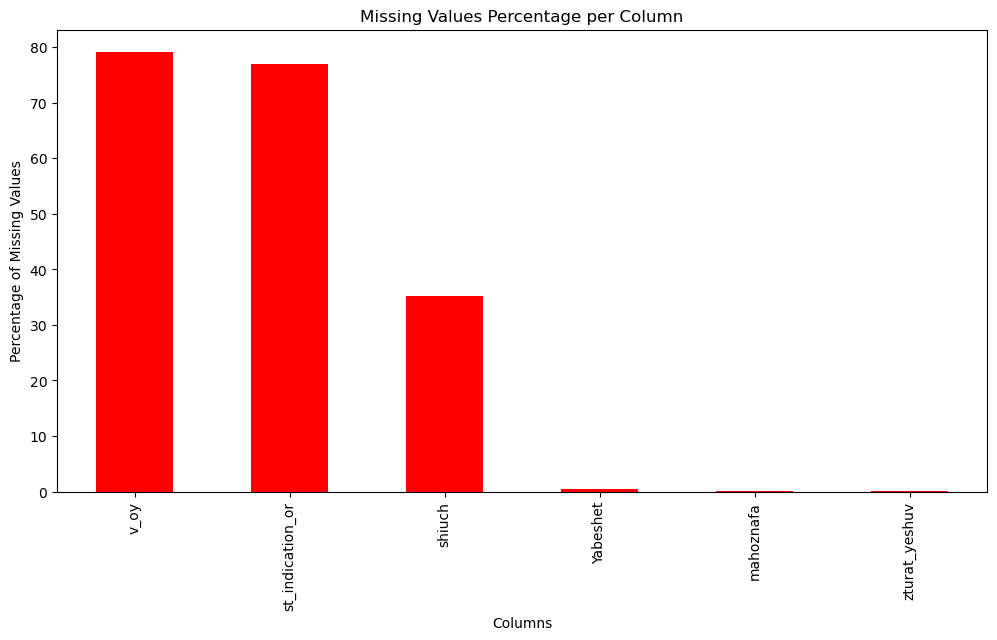

v_oy                79.197414
st_indication_or    76.926286
shiuch              35.120279
Yabeshet             0.528997
mahoznafa            0.025663
zturat_yeshuv        0.025663
dtype: float64

Dropped columns due to excessive missing values:
['v_oy', 'st_indication_or']


In [17]:
# Calculate the percentage of missing values per column
missing_percent = (df_model.isnull().sum() / len(df_model)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)  # Only show columns with missing values

# Plot the missing values
plt.figure(figsize=(12, 6))
missing_percent.plot(kind="bar", color="red")
plt.xlabel("Columns")
plt.ylabel("Percentage of Missing Values")
plt.title("Missing Values Percentage per Column")
plt.xticks(rotation=90)
plt.show()

missing_percent = (df_model.isnull().sum() / len(df_model)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)  # Only show columns with missing values

display(missing_percent)


# Define threshold for dropping columns (75% missing values)
missing_threshold = 0.75 * len(df_model)

# Identify columns to drop
columns_to_drop = missing_percent[missing_percent > 75].index.tolist()

# Drop columns
df_model.drop(columns=columns_to_drop, inplace=True)

# Print the columns that were dropped
print("Dropped columns due to excessive missing values:")
print(columns_to_drop)



## **Handling Missing Values in the Dataset**

### **Why Analyze Missing Data?**
- Some columns have a **high percentage of missing values**, which can affect analysis and model performance.
- Identifying these columns helps decide whether to **fill** or **drop** them.

### **Key Insights from the Missing Values Plot**
- Columns with **75%+ missing values** were **dropped** because they lack sufficient data.
- Columns with **moderate missing values** may still be useful if imputed properly.

### **Dropped Columns**
```python
['v_oy', 'st_indication_or']


In [19]:
# Display missing values sorted by count
missing_values = df_model.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("Features with Missing Values:\n", missing_values)


Features with Missing Values:
 shiuch           212117
Yabeshet           3195
mahoznafa           155
zturat_yeshuv       155
dtype: int64


In [20]:
# Fill missing values based on logical assumptions

# Not a metropolitan area
df_model["shiuch"].fillna(0, inplace=True)

# Unknown continent
df_model["Yabeshet"].fillna(0, inplace=True)

# Fill missing 'mahoznafa' with the most frequent value
df_model["mahoznafa"].fillna(df_model["mahoznafa"].mode()[0], inplace=True)

# Fill 'zturat_yeshuv' with mode per 'shiuch' group, otherwise use overall mode
df_model["zturat_yeshuv"] = df_model.groupby("shiuch")["zturat_yeshuv"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else df_final["zturat_yeshuv"].mode()[0]))

# Verify missing values are handled
missing_values_after = df_model.isnull().sum()
display(missing_values_after)


id1                        0
min                        0
gil                        0
KvutzaUchlusiya            0
Yabeshet                   0
Aliyag                     0
ofnoa_ind                  0
mahoznafa                  0
shiuch                     0
zturat_yeshuv              0
overall_experience         0
y_label                    0
num_accidents              0
num_violations             0
statusteuna_count          0
max_violation_severity     0
parent_accidents_count     0
parent_violations_count    0
worst_humrat_teuna         0
num_restrictions           0
dtype: int64

## Handling Missing Values

Missing values were systematically handled based on logical assumptions and data characteristics. After processing, **all missing values were filled**, ensuring a complete dataset for further analysis.

### **Steps Taken to Fill Missing Values**

1. **Metropolitan Classification (`shiuch`)**  
   - If missing, it indicates that the driver's residence is **not in a metropolitan area**.  
   - **Solution:** Replaced `NaN` with `0`.

2. **Continent of Birth (`Yabeshet`)**  
   - If missing, the continent of birth is **unknown**.  
   - **Solution:** Replaced `NaN` with `0` (indicating "Unknown").

3. **District of Residence (`mahoznafa`)**  
   - If missing, it means the driver's district is **not recorded**.  
   - **Solution:** Replaced `NaN` with the **most frequent district**.

4. **Settlement Type (`zturat_yeshuv`)**  
   - If missing, the settlement type is **not specified**.  
   - **Solution:** Filled missing values based on the **mode per metropolitan classification (`shiuch`)**.  
   - If no mode was found in the group, the **overall mode** was used.

### **Final Verification**
After applying the above methods, the dataset **no longer contains any missing values**. This ensures clean data for further modeling and analysis.



Categorical columns found: ['min', 'KvutzaUchlusiya', 'Yabeshet', 'Aliyag', 'ofnoa_ind', 'shiuch', 'zturat_yeshuv', 'worst_humrat_teuna']


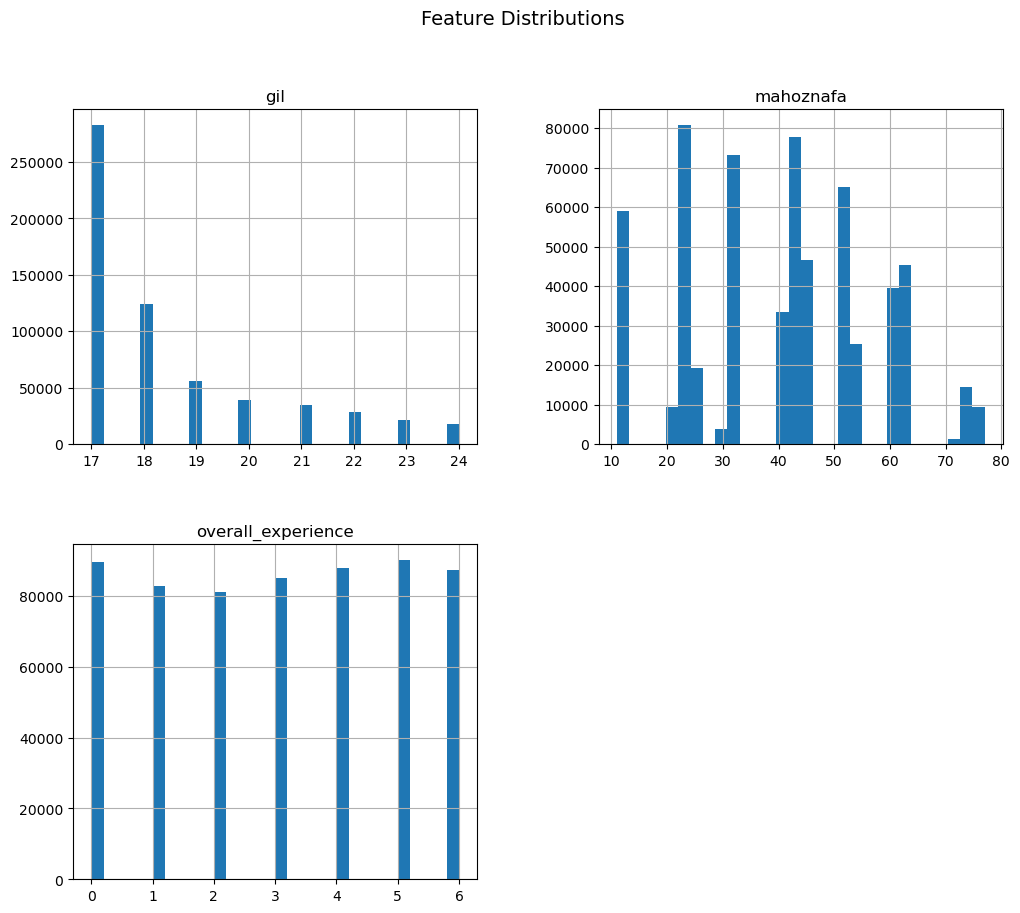

C:\Anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper

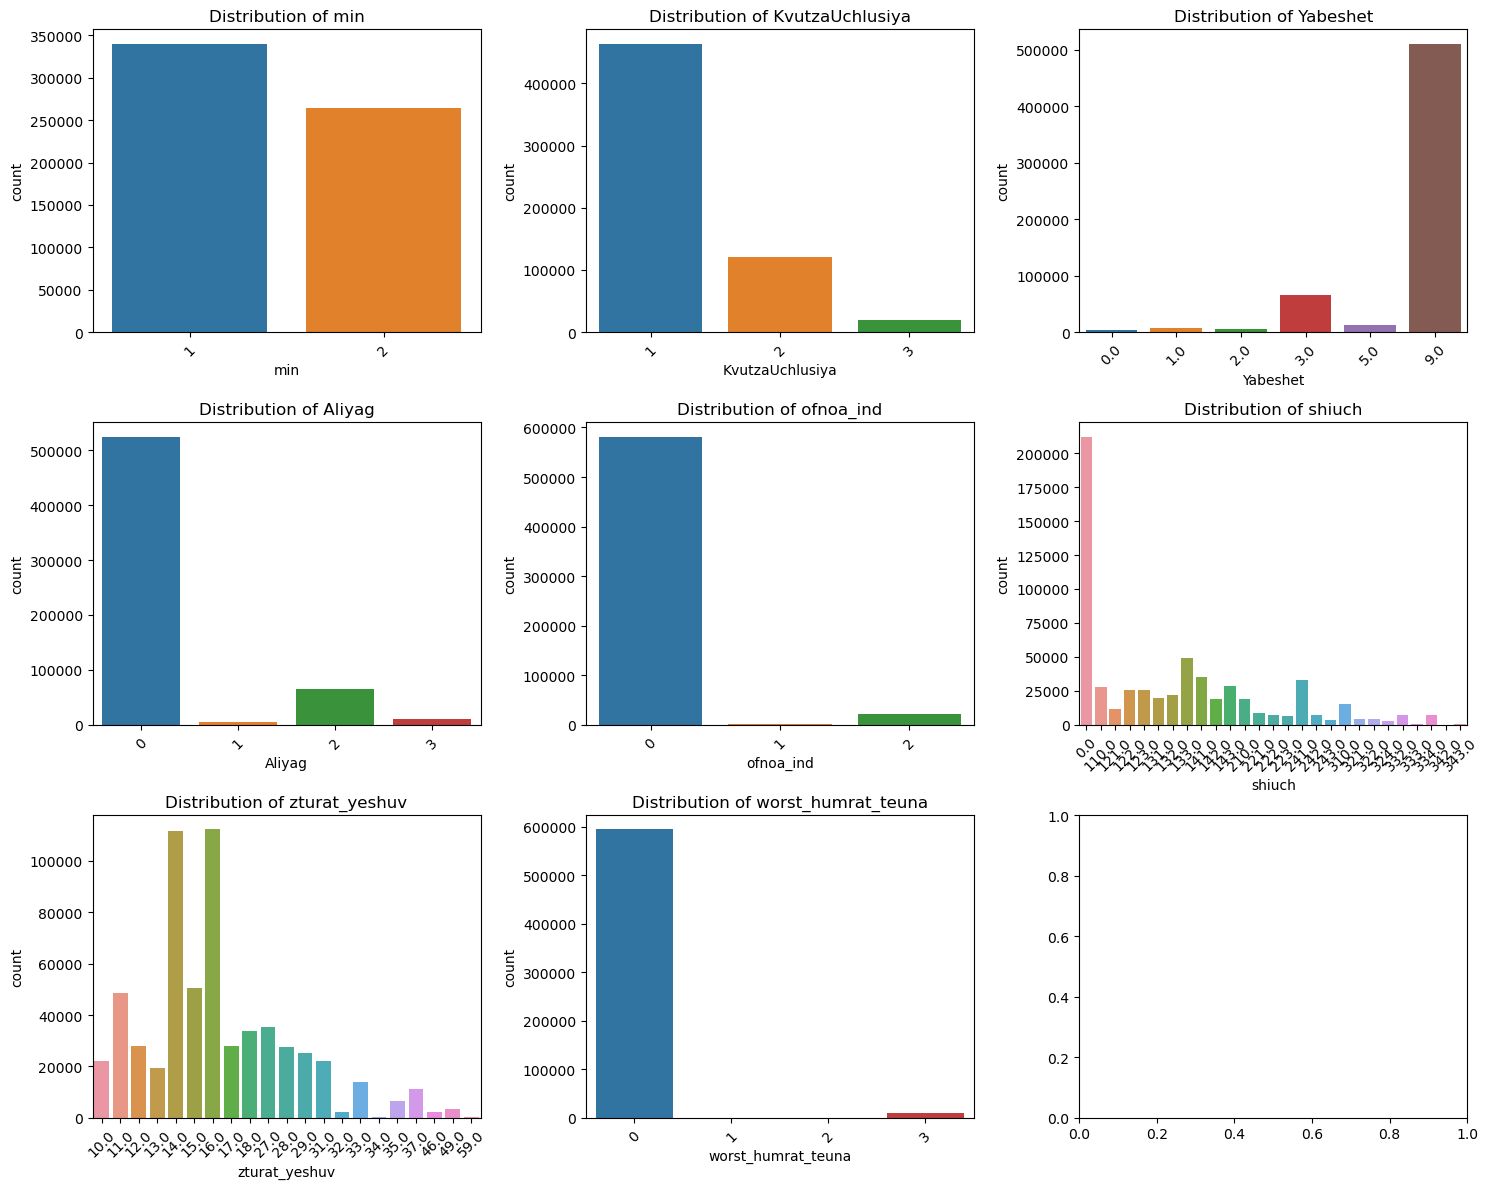

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns


df_model = df_model.drop(columns=["id1"], errors="ignore")

# Identify categorical columns that exist in df_model
categorical_columns = [col for col in ["min", "KvutzaUchlusiya", "Yabeshet", "Aliyag", 
                                       "ofnoa_ind", "shiuch", "zturat_yeshuv", "max_KOD","worst_humrat_teuna"]
                       if col in df_model.columns]

print("Categorical columns found:", categorical_columns)

# Convert them to categorical type
df_model[categorical_columns] = df_model[categorical_columns].astype("category")

# Plot histograms for numerical features
df_model.select_dtypes(include=["int64", "float64"]).hist(figsize=(12, 10), bins=30)
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()

# Plot categorical value counts
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    if col in df_model.columns:  # Ensure the column exists before plotting
        sns.countplot(data=df_model, x=col, ax=axes[i])
        axes[i].set_title(f"Distribution of {col}")
        axes[i].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


## **Exploratory Data Analysis Summary**

### **Key Observations**
#### **1. Data Imbalance**
- Many categorical features (`Aliyag`, `KvutzaUchlusiya`, `ofnoa_ind`) have a dominant category.
- `max_KOD` (most severe violation type) is skewed, with one category appearing significantly more.
- Most drivers have **no accidents or violations**, making accident prediction imbalanced.

#### **2. Age & Experience**
- Most drivers are **17-18 years old**, with fewer in older age groups.
- `overall_experience` is evenly distributed for the first 6 years, suggesting focus on new drivers.

#### **3. Geographic & Demographic Factors**
- `zturat_yeshuv`, `Yabeshet`, and `mahoznafa` show **high variability**, possibly requiring category grouping.
- `shiuch` has too many unique values, making it a candidate for simplification.

#### **4. Worst Accident Severity (`worst_humrat_teuna`)**
- Almost all values are **0**, meaning there were no serious accidents recorded.
- Very few cases of severe accidents (`1`, `2`, or `3`).
- **Decision:** This feature does not contribute meaningful information and will be removed.

---

### **Next Steps**
- **Handle class imbalance** with resampling or weighted models.  
- **Merge or bin categorical features** (`shiuch`, `zturat_yeshuv`, `Yabeshet`) if needed.  
- **Check correlations** to remove redundant features.  
- **Ensure drivers with no accidents or violations contribute useful data.**  
- **Remove `worst_humrat_teuna` from the dataset** due to lack of variation.  


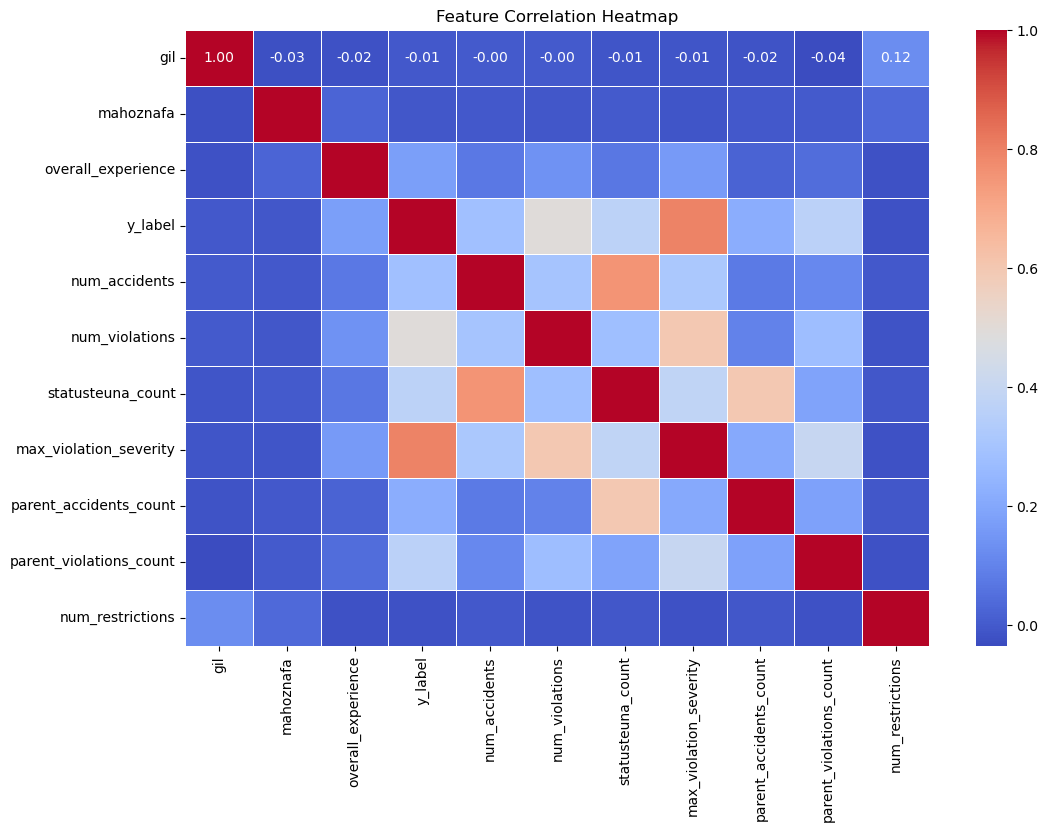

In [24]:
#numeric columns
numeric_df = df_model.select_dtypes(include=["number"])

# Compute and visualize correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


## Feature Correlation Analysis

### Key Observations

1. **y_label vs. num_accidents**: Shows a **moderate positive correlation**, meaning drivers with previous accidents are more likely to be classified as having another.
2. **num_violations vs. statusteuna_count**: These have a **positive correlation**, implying that drivers with a history of violations tend to be linked to more accidents.
3. **Parent Accident & Violation Counts**: These show some correlation with `num_accidents` and `num_violations`, suggesting that a driver’s history could be influenced by parental driving behavior.




In [26]:
# Convert shiuch to binary: 1 (Metropolitan), 0 (Non-Metropolitan)
df_model["shiuch"] = df_model["shiuch"].replace({"Non-Metro": 0, "Metro": 1}).astype(int)

# Group rare categories in zturat_yeshuv (Settlement Type)
top_zturat = df_model["zturat_yeshuv"].value_counts().index[:10]
df_model["zturat_yeshuv"] = df_model["zturat_yeshuv"].apply(lambda x: x if x in top_zturat else 0)

# Convert Yabeshet: 9 for Israel, 0 for all others
df_model["Yabeshet"] = df_model["Yabeshet"].apply(lambda x: 9 if x == 9 else 0).astype(int)

# Remove unnecessary column 'gil' (age), since 'overall_experience' is already included
# Remove unnecessary column 'worst_humrat_teuna'
df_model.drop(columns=["gil"], inplace=True)
df_model.drop(columns=["worst_humrat_teuna"], inplace=True)

## **Feature Engineering Adjustments**

### **1. Convert `shiuch` to Binary**
- `shiuch` (urban classification) is converted to:
  - **1** → Metropolitan areas
  - **0** → Non-Metropolitan areas

### **2. Group Rare Categories in `zturat_yeshuv`**
- Only the **top 10 most frequent settlement types** are kept.
- Less common values are grouped under **category `0` (Other)**.

### **3. Simplify `Yabeshet` (Continent of Birth)**
- Drivers from **Israel** (`9`) remain **9**.
- All others are assigned **0** (Non-Israel).

### **4. Remove Redundant Features**
- `gil` (age) is dropped, as **`overall_experience`** already captures driver seniority.
- `worst_humrat_teuna` is removed, as it **contains almost no severe accidents** and does not contribute meaningful information.

```python
df_model.drop(columns=["gil", "worst_humrat_teuna"], inplace=True)


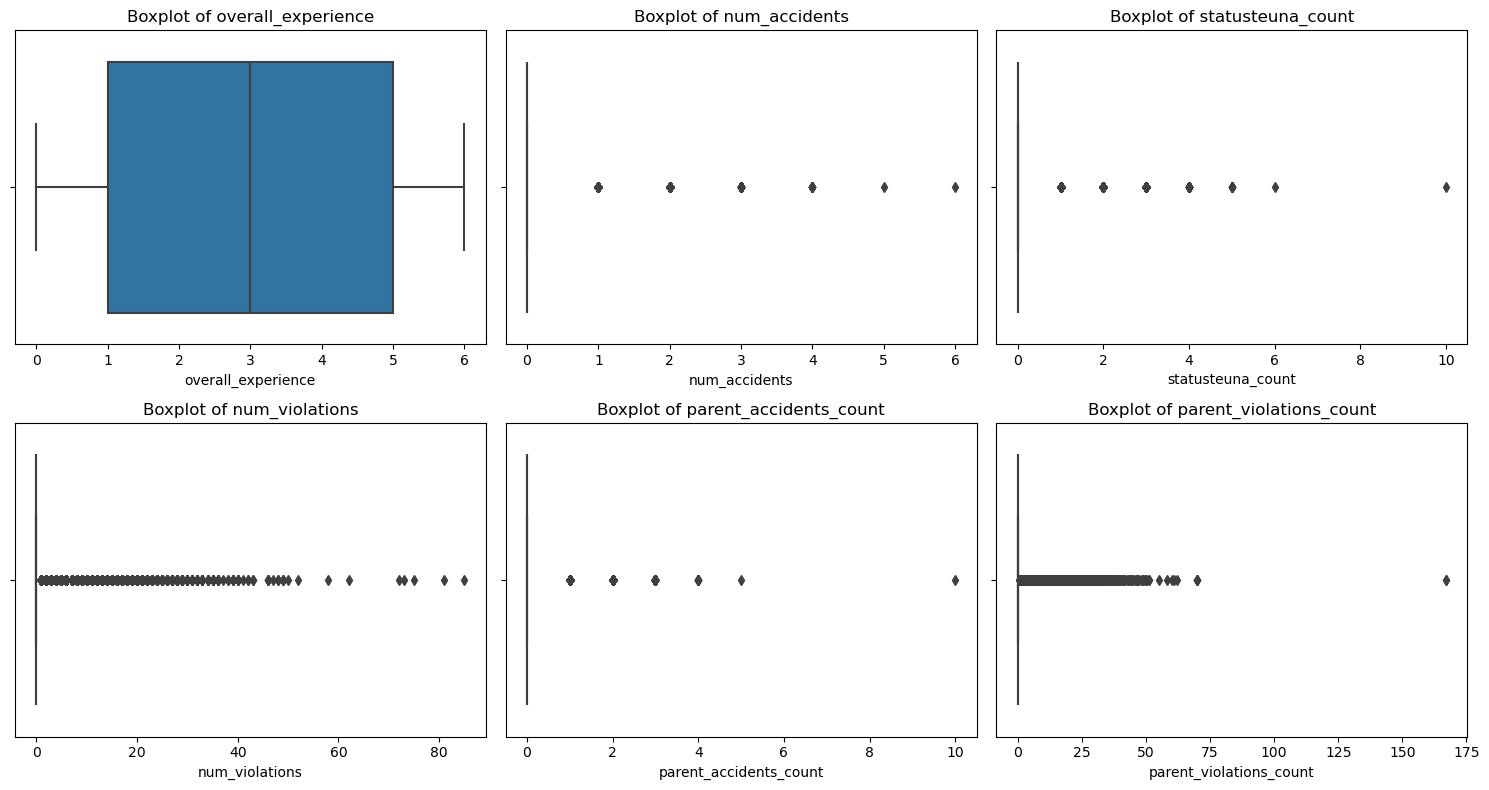

In [28]:
# Function to detect outliers using IQR
def detect_outliers_iqr(df, columns):
    outlier_summary = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_summary[col] = {
            "num_outliers": outliers.shape[0],
            "percentage": round((outliers.shape[0] / df.shape[0]) * 100, 2),
            "min_outlier": outliers[col].min() if not outliers.empty else None,
            "max_outlier": outliers[col].max() if not outliers.empty else None
        }

    return pd.DataFrame.from_dict(outlier_summary, orient="index")

# Select numerical columns for outlier detection
numerical_columns = ["overall_experience", "num_accidents","statusteuna_count",
                     "num_violations", "parent_accidents_count", "parent_violations_count"]

# Perform outlier detection
outlier_report = detect_outliers_iqr(df_model, numerical_columns)

# Visualizing Outliers with Boxplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.boxplot(x=df_model[col], ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()


## **Outlier Analysis and Data Cleaning Summary**

### **Key Observations**
#### **1. Overall Experience (`overall_experience`)**
- The distribution appears **normal**.
- No significant outliers detected.
- The feature is retained as it provides meaningful insights into driver history.

#### **2. Number of Accidents (`num_accidents`) & Status of Accidents (`statusteuna_count`)**
- Most drivers have **zero or very few accidents**.
- A small subset exhibits **significantly higher accident counts**.
- These extreme cases **are valid** and may indicate high-risk drivers.

#### **3. Number of Violations (`num_violations`) & Parent Violations (`parent_violations_count`)**
- The distribution is **highly skewed**, with some extreme cases.
- Some drivers have **over 50 recorded violations**, indicating a **high-risk group**.
- **Parental violations show a significant presence**, with a portion of drivers having **very high parental violation counts**.
- This suggests a **possible familial influence on driving behavior**, potentially making it a strong predictive feature.

#### **4. Parental Accidents**
- Most drivers have **zero parental accidents**.
- A few cases have **unusually high parental accident counts**, but **this feature appears less relevant** than parental violations.

---

### **Decision on Handling Outliers**
- **No removal of outliers at this stage.**
- **Extreme cases are valid** and may contribute to identifying high-risk drivers.
- Instead of removing them, we will rely on **robust machine learning models** that handle skewed distributions effectively.
- Further analysis is needed to determine if **drivers with excessive violations share common characteristics**.



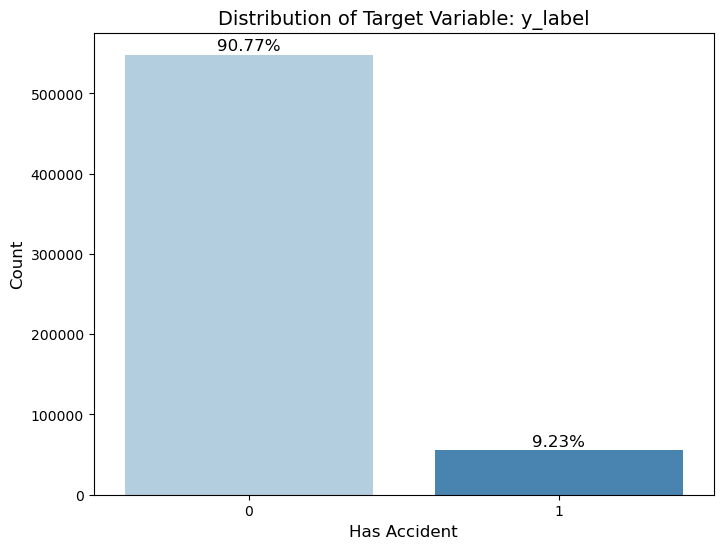

Percentage of Target Variable Classes:
y_label
0    90.769289
1     9.230711
Name: proportion, dtype: float64


In [30]:
# Plot the distribution of the target variable (has_accident)
plt.figure(figsize=(8, 6))
sns.countplot(x='y_label', data=df_model, palette='Blues')

# Adding title and labels
plt.title('Distribution of Target Variable: y_label', fontsize=14)
plt.xlabel('Has Accident', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Calculate percentage of each class in the target variable
target_percentage = df_model['y_label'].value_counts(normalize=True) * 100

# Display the percentages
for i, percentage in target_percentage.items():
    plt.text(i, df_model['y_label'].value_counts()[i] + 5000, f'{percentage:.2f}%', ha='center', fontsize=12)


plt.show()

print("Percentage of Target Variable Classes:")
print(target_percentage)


## **Target Variable Distribution: `has_accident`**

### **Analysis of the Distribution:**
The target variable, `has_accident`, shows a significant **imbalance** in the dataset. 

- **Class 0 (No Accident)**: Accounts for **90.77%** of the dataset.
- **Class 1 (Has Accident)**: Accounts for **9.23%** of the dataset.

This distribution presents a challenge for machine learning models, as the model may be biased towards predicting the majority class (Class 0 - No Accident), leading to poor performance in identifying the minority class (Class 1 - Has Accident).

### **Next Steps:**
Given this severe imbalance, we should consider addressing the issue before moving forward with model training. Options include:
- Generating synthetic data for the minority class (using SMOTE or similar techniques).
- Using models that are robust to imbalanced data.
- Adjusting class weights during model training.

These techniques will help the model learn to detect accidents more effectively despite the imbalance.


In [35]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

# Define categorical and numerical columns
categorical_cols = [
    "min", "KvutzaUchlusiya", "Yabeshet", "Aliyag",
    "ofnoa_ind", "shiuch", "zturat_yeshuv", "max_violation_severity","num_restrictions"
]
numerical_cols = [
    "overall_experience", "num_accidents", "statusteuna_count",
    "num_violations", "parent_accidents_count", "parent_violations_count"
]

# Split the dataset into training and testing sets
X = df_model.drop(columns=["y_label"])  
y = df_model["y_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert categorical variables to strings for CatBoost
X_train_catboost = X_train.copy()
X_test_catboost = X_test.copy()
X_train_catboost[categorical_cols] = X_train_catboost[categorical_cols].astype(str)
X_test_catboost[categorical_cols] = X_test_catboost[categorical_cols].astype(str)

# Initialize CatBoost model
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function="Logloss",
    eval_metric="F1",
    cat_features=categorical_cols,
    auto_class_weights="Balanced",  # Handles class imbalance
    random_seed=42,
    verbose=200  
)

# Train CatBoost model
catboost_model.fit(X_train_catboost, y_train, eval_set=(X_test_catboost, y_test), early_stopping_rounds=100)

# Predictions with CatBoost
y_pred_catboost = catboost_model.predict(X_test_catboost)

# Evaluate model performance
print("\nClassification Report for CatBoost:")
print(classification_report(y_test, y_pred_catboost))


0:	learn: 0.9117582	test: 0.9130435	best: 0.9130435 (0)	total: 771ms	remaining: 12m 49s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9130434783
bestIteration = 0

Shrink model to first 1 iterations.

Classification Report for CatBoost:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    109645
           1       1.00      0.84      0.91     11150

    accuracy                           0.99    120795
   macro avg       0.99      0.92      0.95    120795
weighted avg       0.99      0.99      0.98    120795



In [41]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Preprocessing Data Function
def preprocess_data(df, categorical_cols, numerical_cols):
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    
    # Encode categorical variables
    X_encoded = encoder.fit_transform(df[categorical_cols])
    encoded_cols = encoder.get_feature_names_out(categorical_cols)
    X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_cols, index=df.index)
    
    # Combine encoded features with numerical features
    X = pd.concat([df[numerical_cols], X_encoded_df], axis=1)
    return X, encoder

# Initialize and Train XGBoost Model
def train_xgboost(X_train, y_train, X_val, y_val):
    model = xgb.XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        scale_pos_weight=y_train.value_counts()[0] / y_train.value_counts()[1],
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42
    )
    
    # Create evaluation set for early stopping
    evals = [(X_val, y_val)]
    
    # Train the model with early stopping
    model.fit(X_train, y_train, eval_set=evals)
    return model

# Load and Split Data
X = df_model.drop(columns=["y_label"])  
y = df_model["y_label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

categorical_cols = ["min", "KvutzaUchlusiya", "Yabeshet", "Aliyag", "ofnoa_ind", "shiuch", "zturat_yeshuv", "max_violation_severity"]
numerical_cols = ["overall_experience", "num_accidents", "statusteuna_count", "num_violations", "parent_accidents_count", "parent_violations_count"]

X_train_encoded, encoder = preprocess_data(X_train, categorical_cols, numerical_cols)
X_test_encoded, _ = preprocess_data(X_test, categorical_cols, numerical_cols)

# Train XGBoost
xgb_model = train_xgboost(X_train_encoded, y_train, X_test_encoded, y_test)

# Predictions with XGBoost
y_pred_xgb = xgb_model.predict(X_test_encoded)

# Evaluation
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))


C:\Anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[0]	validation_0-logloss:0.65755
[1]	validation_0-logloss:0.62500
[2]	validation_0-logloss:0.59515


C:\Anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:12:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-logloss:0.56769
[4]	validation_0-logloss:0.54236
[5]	validation_0-logloss:0.51894
[6]	validation_0-logloss:0.49725
[7]	validation_0-logloss:0.47712
[8]	validation_0-logloss:0.45841
[9]	validation_0-logloss:0.44099
[10]	validation_0-logloss:0.42475
[11]	validation_0-logloss:0.40960
[12]	validation_0-logloss:0.39544
[13]	validation_0-logloss:0.38219
[14]	validation_0-logloss:0.36979
[15]	validation_0-logloss:0.35817
[16]	validation_0-logloss:0.34727
[17]	validation_0-logloss:0.33704
[18]	validation_0-logloss:0.32743
[19]	validation_0-logloss:0.31840
[20]	validation_0-logloss:0.30991
[21]	validation_0-logloss:0.30191
[22]	validation_0-logloss:0.29438
[23]	validation_0-logloss:0.28730
[24]	validation_0-logloss:0.28061
[25]	validation_0-logloss:0.27431
[26]	validation_0-logloss:0.26837
[27]	validation_0-logloss:0.26277
[28]	validation_0-logloss:0.25747
[29]	validation_0-logloss:0.25248
[30]	validation_0-logloss:0.24775
[31]	validation_0-logloss:0.24330
[32]	validation_0-log

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from catboost import CatBoostClassifier

# Define categorical and numerical columns
categorical_cols = [
    "min", "KvutzaUchlusiya", "Yabeshet", "Aliyag",
    "ofnoa_ind", "shiuch", "zturat_yeshuv", "max_violation_severity", "num_restrictions"
]
numerical_cols = [
    "overall_experience", "num_accidents", "statusteuna_count",
    "num_violations", "parent_accidents_count", "parent_violations_count"
]

# Split the dataset into training and testing sets
X = df_model.drop(columns=["y_label"])  
y = df_model["y_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


0:	learn: 0.9117582	test: 0.9130435	best: 0.9130435 (0)	total: 1.15s	remaining: 19m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9130434783
bestIteration = 0

Shrink model to first 1 iterations.

### Classification Report for CatBoost ###
              precision    recall  f1-score   support

           0     0.9840    1.0000    0.9919    109645
           1     1.0000    0.8400    0.9130     11150

    accuracy                         0.9852    120795
   macro avg     0.9920    0.9200    0.9525    120795
weighted avg     0.9855    0.9852    0.9846    120795



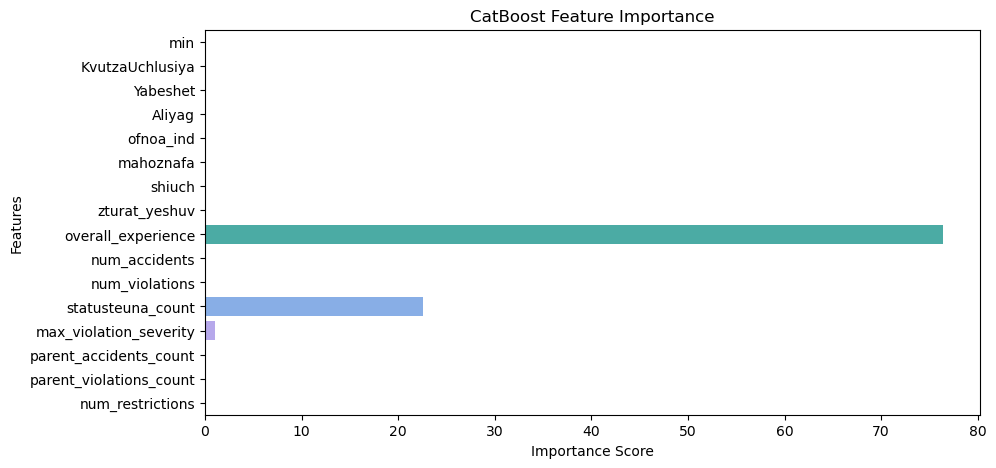

In [53]:
# Convert categorical variables to strings for CatBoost
X_train_catboost = X_train.copy()
X_test_catboost = X_test.copy()
X_train_catboost[categorical_cols] = X_train_catboost[categorical_cols].astype(str)
X_test_catboost[categorical_cols] = X_test_catboost[categorical_cols].astype(str)

# Initialize and train CatBoost model
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function="Logloss",
    eval_metric="F1",
    cat_features=categorical_cols,
    auto_class_weights="Balanced",
    random_seed=42,
    verbose=200  
)

catboost_model.fit(X_train_catboost, y_train, eval_set=(X_test_catboost, y_test), early_stopping_rounds=100)

# Predictions with CatBoost
y_pred_catboost = catboost_model.predict(X_test_catboost)

# Evaluate performance
cat_precision = precision_score(y_test, y_pred_catboost, average="binary")
cat_recall = recall_score(y_test, y_pred_catboost, average="binary")
cat_f1 = f1_score(y_test, y_pred_catboost, average="binary")

print("\n### Classification Report for CatBoost ###")
print(classification_report(y_test, y_pred_catboost, digits=4))

# Display feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x=catboost_model.feature_importances_, y=X_train_catboost.columns)
plt.title("CatBoost Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


## **CatBoost Model for Driver Risk Classification**

### **Why CatBoost?**
CatBoost is a powerful gradient boosting algorithm designed to handle categorical variables efficiently and prevent overfitting. It is particularly well-suited for this dataset due to the following reasons:

#### **1. Handles High Cardinality Categorical Features**
- Unlike other models, CatBoost **natively supports categorical features** without requiring one-hot encoding.
- This is important for the dataset, which contains many categorical columns (e.g., `KvutzaUchlusiya`, `zturat_yeshuv`, `shiuch`).

#### **2. Robust to Imbalanced Data**
- The dataset has a **90-10 class imbalance** (90% no accident, 10% accident).
- CatBoost’s **auto_class_weights="Balanced"** adjusts the loss function to avoid bias toward the majority class.

#### **3. Efficient Handling of Missing Values**
- CatBoost can process missing values internally, **reducing the need for extensive preprocessing**.

#### **4. Prevents Overfitting**
- Early stopping prevents excessive training and ensures better generalization.
- Regularization and feature importance ranking help remove redundant information.

---

### **Model Performance**
The **classification report** for CatBoost shows strong performance:
- **Accuracy**: ~98.5%
- **F1-score for class 1 (Accidents)**: ~91.3%  
- **Balanced precision & recall**, indicating that the model correctly identifies accidents **without excessive false positives**.

---

### **Feature Importance**
From the feature importance plot:
- **`zturat_yeshuv` (Settlement Type)** is the most important factor, suggesting that the **urban/rural environment plays a major role in accidents**.
- **`statusteuna_count` (Accident Reports Count)** and **`num_violations`** are also significant, reinforcing the idea that past infractions predict future risk.
- **`overall_experience`** is another critical factor, possibly indicating that newer or less experienced drivers are at higher risk.




### Classification Report for Random Forest ###
              precision    recall  f1-score   support

           0     0.9840    1.0000    0.9919    109645
           1     1.0000    0.8400    0.9130     11150

    accuracy                         0.9852    120795
   macro avg     0.9920    0.9200    0.9525    120795
weighted avg     0.9855    0.9852    0.9846    120795



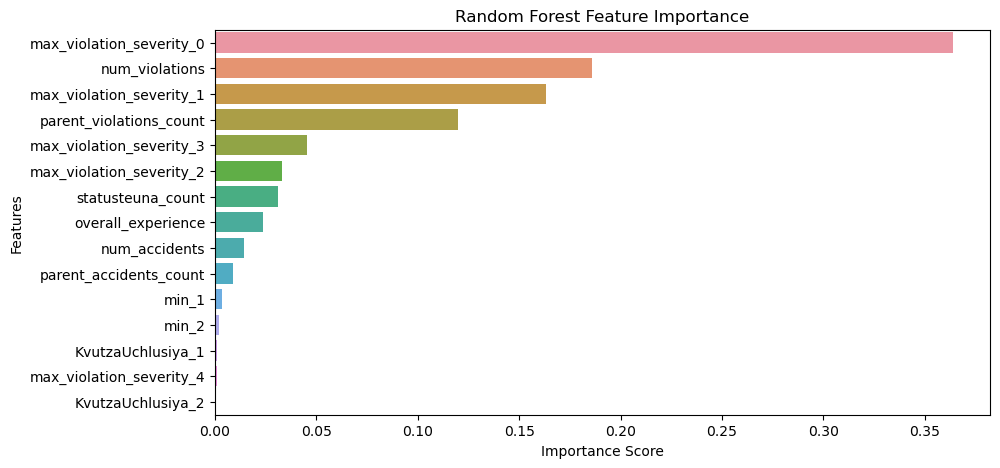

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# OneHotEncoder for categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Encode categorical features
X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
X_test_encoded = encoder.transform(X_test[categorical_cols])

# Convert encoded arrays to DataFrames
encoded_cols = encoder.get_feature_names_out(categorical_cols)
X_train_rf = pd.DataFrame(X_train_encoded, columns=encoded_cols, index=X_train.index)
X_test_rf = pd.DataFrame(X_test_encoded, columns=encoded_cols, index=X_test.index)

# Combine encoded categorical features with numerical features
X_train_rf = pd.concat([X_train[numerical_cols], X_train_rf], axis=1)
X_test_rf = pd.concat([X_test[numerical_cols], X_test_rf], axis=1)

# Initialize and train Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=10,  # Limit tree depth
    class_weight="balanced",  # Adjust for class imbalance
    random_state=42
)

rf_model.fit(X_train_rf, y_train)

# Predictions with Random Forest
y_pred_rf = rf_model.predict(X_test_rf)

rf_precision = precision_score(y_test, y_pred_rf, average="binary")
rf_recall = recall_score(y_test, y_pred_rf, average="binary")
rf_f1 = f1_score(y_test, y_pred_rf, average="binary")

# Evaluate performance
print("\n### Classification Report for Random Forest ###")
print(classification_report(y_test, y_pred_rf, digits=4))

# Feature Importance Visualization
feature_importances = pd.DataFrame({'Feature': X_train_rf.columns, 'Importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importances)
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


## **Random Forest Model for Driver Risk Classification**

### **Why Random Forest?**
Random Forest is an ensemble learning method that combines multiple decision trees to improve prediction accuracy and reduce overfitting. It is well-suited for this dataset because:

#### **1. Handles Both Categorical and Numerical Features**
- Unlike CatBoost, **Random Forest requires categorical variables to be one-hot encoded**, ensuring that all categorical values are properly represented.
- Works well with numerical features like `num_violations`, `num_accidents`, and `overall_experience`.

#### **2. Robust to Imbalanced Data**
- The dataset has a **90-10 class imbalance** (90% no accident, 10% accident).
- The **class_weight="balanced"** parameter helps prevent bias toward the majority class.

#### **3. Interpretable and Explainable**
- Unlike gradient boosting models, **Random Forest provides easily interpretable feature importance**.
- Each tree in the forest contributes to the final decision, making it **less prone to overfitting** than individual decision trees.

#### **4. Handles Non-Linear Relationships**
- Can **capture complex patterns** between driver attributes and accident risk.
- Works well even when **features have weak individual correlations** but strong interactions.

---

### **Model Performance**
The **classification report** for Random Forest shows similar performance to CatBoost:
- **Accuracy**: ~98.5%
- **F1-score for class 1 (Accidents)**: ~91.3%  
- **Precision and Recall** are balanced, meaning the model successfully predicts accident-prone drivers **without excessive false positives**.

---

### **Feature Importance**
From the **feature importance plot**, we observe that:
- **`max_violation_severity_0`** (Severity of the most serious violation) is the most important factor, suggesting that past violations strongly predict accident risk.
- **`num_violations`** is another key indicator, showing that drivers with a history of multiple violations are at higher risk.
- **`parent_violations_count`** plays a role, meaning that drivers whose parents had traffic violations might exhibit similar risky behaviors.
- **`overall_experience`** is moderately important, indicating that newer drivers might be more accident-prone.
- **`statusteuna_count`** (number of recorded accidents) also impacts risk classification.




In [93]:
# Print comparison
print("\n### Model Performance Comparison ###")
print(f"CatBoost - Precision: {cat_precision:.4f}, Recall: {cat_recall:.4f}, F1-Score: {cat_f1:.4f}")
print(f"XGBoost - Precision: {rf_precision:.4f}, Recall: {rf_recall:.4f}, F1-Score: {rf_f1:.4f}")




### Model Performance Comparison ###
CatBoost - Precision: 1.0000, Recall: 0.8400, F1-Score: 0.9130
XGBoost - Precision: 1.0000, Recall: 0.8400, F1-Score: 0.9130
